# Problem Overview
In this project, we use supervised learning models to identify customers who are likely to stop using service in the future. Furthermore, we will analyze top factors that influence user retention. 

Following are the main steps in the proposed approach:
1. Data Exploration Analysis (EDA)
2. Feature Processing
3. Model Training & Result Evaluation
4. Feature Selection


# Part 0: Setup Environment

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Part 1: Data Exploration

In [7]:
raw_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
raw_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

Demographic information about customers:
- **customerID:**
- **gender:**
- **SeniorCitizen:** Whether the customer is a senior citizen or not (1, 0)
- **Partner:** Whether the customer has a partner or not (Yes, No)
- **Dependents:** Whether the customer has dependents or not (Yes, No)
- **tenure:** Number of months the customer has stayed with the company

Services that each customer has signed up for:
- **PhoneService:** Whether the customer has a phone service or not (Yes, No)
- **MultipleLines:** Whether the customer has multiple lines or not (Yes, No, No phone service)
- **InternetService:** Customer's internet service provider (DSL, Fiber optic, No)
- **OnlineSecurity:** Whether the customer has online security or not (Yes, No, No internet service)
- **OnlineBackup:** Whether the customer has online backup or not (Yes, No, No internet service)
- **DeviceProtection:** Whether the customer has device protection or not (Yes, No, No internet service)
- **TechSupport:** Whether the customer has tech support or not (Yes, No, No internet service)
- **StreamingTV:** Whether the customer has streaming TV or not (Yes, No, No internet service)
- **StreamingMovies:** Whether the customer has streaming movies or not (Yes, No, No internet service)

Customer account information:
- **Contract:** The contract term of the customer (Month-to-month, One year, Two year)
- **PaperlessBilling:** Whether the customer has paperless billing or not (Yes, No)
- **PaymentMethod:** The customer's payment method (Eletronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- **MonthlyCharges:** The amount charged to the customer monthly
- **TotalCharges:** The total amount charged to the customer

- **Churn:** Customers who left within the last month

### Part 1.1: Understand the Raw Dataset

In [36]:
import pandas_profiling
pandas_profiling.ProfileReport(raw_data)

### Part 1.2: Data cleaning

Warning message 'HIGH CARDINALITY UNIFORM' on the **TotalCharges**
<br> To deal with it, we need to convert the feature's type from categorical to float. And we find there're some spaces contained in the column, so the first thing to do is treatting the spaces as missing values. Dropping null values from total charges column which contain .15% missing data.

In [37]:
# Replacing spaces with null values
raw_data.TotalCharges = raw_data.TotalCharges.replace(" ", np.nan) # The text file containing the data had some space (so not visible)

# Missing values
raw_data.TotalCharges.isnull().sum()

# Dropping the missing values from TotalCharges column
raw_data = raw_data[raw_data.TotalCharges.notnull()]

# Resetting the index of data without missing values
data = raw_data.reset_index()[raw_data.columns]

# Convertting to float type
data.TotalCharges = data.TotalCharges.astype(float)

# data without missing values
data.shape

(7032, 21)

The categorical variables: **'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', and 'StreamingMovies'** all have 3 levels: 'Yes', 'No', 'No internet service'.

In [38]:
# Categorical variables
cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Replace 'No internet service' by 'No'
for i in cols : 
    data[i] = data[i].replace({'No internet service' : 'No'})
    
# Replace values in SeniorCitizen
data.SeniorCitizen = data.SeniorCitizen.replace({1:"Yes", 0:"No"})

In column **'InternetService'**, the number observations in the level 'No' is 1526. Which counts 

### Part 1.3:  Understand the features

In [39]:
# The customer_id variable
Id_col = ['customerID']

# The response variable
target_col = ['Churn']

# get the categorical columns (names)
cat_cols = data.nunique()[data.nunique() < 6].keys().tolist()
cat_cols = [x for x in cat_cols if x not in target_col]

# get the numerical columns
num_cols = [x for x in data.columns if x not in cat_cols + target_col + Id_col]
print(num_cols)

# get the binary columns
bin_cols = data.nunique()[data.nunique() == 2].keys().tolist()
print(bin_cols)

# get the multiple-category categorical variables 
multi_cols = [x for x in cat_cols if x not in bin_cols]
print(multi_cols)

['tenure', 'MonthlyCharges', 'TotalCharges']
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']
['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod']


**Make histograms for each numerical variable** 

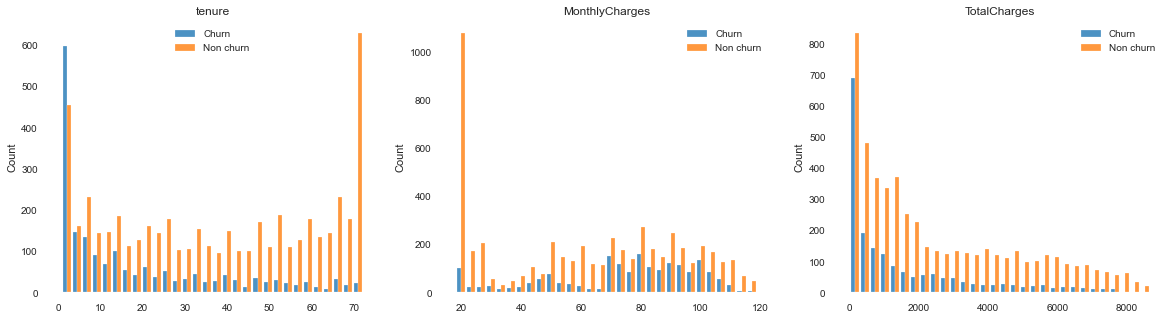

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] 

# seperate customers: churn, non churn
churn = data[data.Churn == "Yes"]
not_churn = data[data.Churn == "No"]

# check the numerical features distribution
fig, ax = plt.subplots(1,3,figsize=(20, 5))
cols = ('tab:blue','tab:orange')

for i in range(3):
    num_col = num_cols[i]

    ax.flat[i].hist([churn[num_col], not_churn[num_col]], color = cols, alpha = 0.8, label=['Churn', 'Non churn'], bins = 30)
    ax.flat[i].set_title(num_col)
    ax.flat[i].set_ylabel("Count")
    ax.flat[i].legend();  

**Make barplots for each categorical variable**
<br> Exploratory Data Analysis (EDA) step that you might want to do on categorical features is the frequency distribution of categories within the feature, which can be done with the .value_counts() 

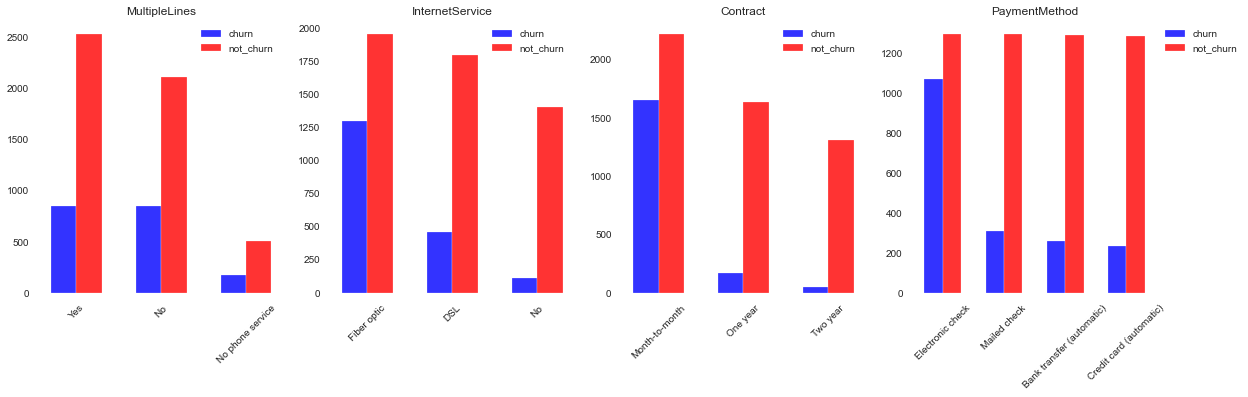

In [41]:
fig, ax = plt.subplots(1,4,figsize=(20, 5))
cols = ('tab:blue','tab:red')

for i in range(4):
    
    column = multi_cols[i]
    counts_churn = churn[column].value_counts()
    counts_not_churn = not_churn[column].value_counts()
    
    xlabels = counts_churn.index.tolist()
    index = np.arange(len(xlabels))
    
    ax[i].bar(index, counts_churn.values, width = -0.3, color = 'blue', label = 'churn', align = 'edge', alpha = 0.8)
    ax[i].bar(index, counts_not_churn.values, width = 0.3, color = 'red', label = 'not_churn', align = 'edge', alpha = 0.8)
    
    ax[i].set_title(column)
    ax[i].set_xticks(index)
    ax[i].set_xticklabels(xlabels, rotation = 45)
    ax[i].legend(bbox_to_anchor=(1, 1));


## Part 2: Feature Preprocessing

**Label encoding** is pretty much intuitive and straight-forward and may give you a good performance from your learning algorithm. This encoding method is a very popular way to encode in the binary variable (levels = 2).

In [56]:
from sklearn.preprocessing import LabelEncoder

# Label encoding Binary columns, convert [yes, no] to [1, 0]
le = LabelEncoder()
for x in bin_cols:
    data[x] = le.fit_transform(data[x])

**One-hot encoding** creates dummy/indicator variables (1 or 0). It converts each category value into a new column and assign a 1 or 0 (True/False) value to the column. It encodes the categorical (levels >=3) features to numeric quantities 

In [57]:
# Make dummy variables for multi value columns
print(multi_cols)

churn_dfThe basic strategy is to convert each category value into a new column and assign a 1 or 0 (True/False) value to the column. This has the benefit of not weighting a value improperly. = pd.get_dummies(data = data, columns = multi_cols)
churn_df.head()

['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,0,1,0,1,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
1,5575-GNVDE,1,0,0,0,34,1,1,0,1,...,1,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,1,0,0,0,2,1,1,1,0,...,1,0,0,1,0,0,0,0,0,1
3,7795-CFOCW,1,0,0,0,45,0,1,0,1,...,1,0,0,0,1,0,1,0,0,0
4,9237-HQITU,0,0,0,0,2,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0


**Correlations Matrix**

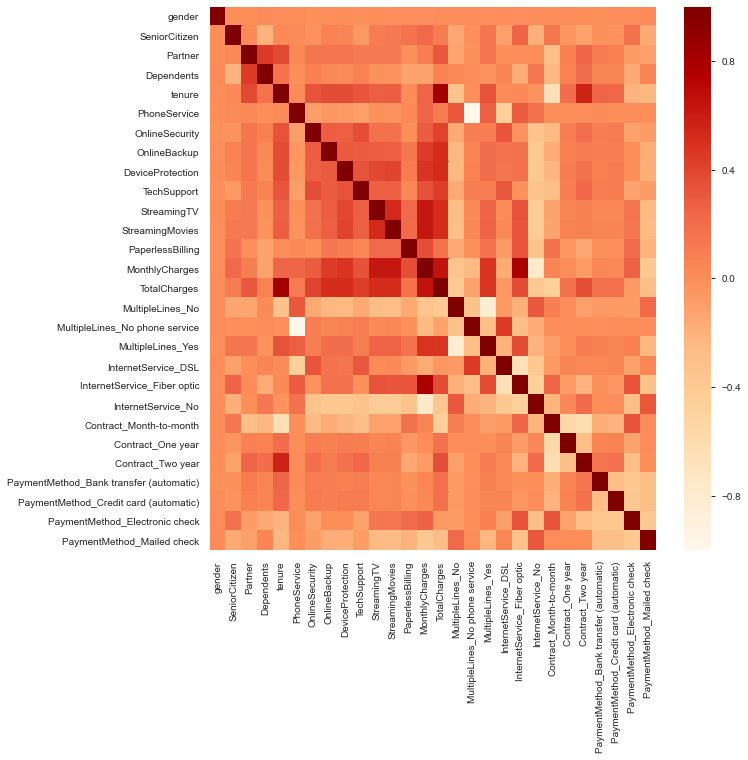

In [58]:
import seaborn as sns

Id_col = ['customerID'] # The customer_id variable
target_col = ['Churn'] # The response variable

#features columns
feature_cols = [x for x in churn_df if x not in target_col + Id_col]

# correlations between all the features
corr = churn_df[feature_cols].corr()

# show heapmap of correlations
sns.heatmap(corr, cmap='OrRd');

In [59]:
# correlation between 'TotalCharges' and 'tenure'
np.corrcoef(churn_df.TotalCharges, churn_df.tenure)[0,1]

0.8258804609332017